# Transaction Date Conversion and Min-Max Normalization

> **Input:** `handle_missing_data/output_data/4_discount_applied/final_cleaned_dataset.csv`  
> **Output:** `handle_rescale_data/output_data/transaction_date/data_rescaling_norm_transaction_date.csv`


## Overview

**Transaction Date** is currently stored as a string (YYYY-MM-DD format). Before it can be used in machine learning models, it must be:
1. **Converted to numeric format** (Unix timestamp in seconds)
2. **Rescaled using Min-Max Normalization** to [0, 1] range

## Why Min-Max Normalization for Transaction Date?

| Method  | Reason |
|--------|--------|
| **Min-Max Normalization** | Dates have clear bounds (min/max in dataset); no outliers; interpretable [0,1] scale |
| **Standardization**  | Large magnitude timestamps make mean/std less interpretable |
| **Robust Scaling** | Unnecessary (no outliers in temporal data) |

**Selected Method:** **Min-Max Normalization**

**Interpretation:**
- **0** = Earliest transaction in dataset
- **1** = Most recent transaction in dataset
- **0.5** = Midpoint of data collection period


## Conversion Strategy

**Unix Timestamp**
- Seconds since epoch (1970-01-01 00:00:00 UTC)
- Formula: `pd.to_datetime(df['Transaction Date']).astype(np.int64) // 10**9`
- **Pros:** Standard ML approach; reversible; preserves chronological order
- **Cons:** Large values (~1.6-1.7 billion), but normalized afterward


In [2]:
# === Setup: Import libraries ===
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
INPUT_CSV = Path("../../output/1_handle_missing_data/final_cleaned_dataset.csv")
OUTPUT_CSV = Path("../../output/3_handle_rescale_data/data_rescaling_norm_transaction_date.csv")

# Column names
DATE_COL = "Transaction Date"
DATE_NUMERIC_COL = "Transaction Date Numeric"
DATE_SCALED_COL = "Transaction Date Scaled"


## Step 1: Load Dataset

Load the cleaned dataset from the missing data handling pipeline.

In [3]:
# Load dataset
df = pd.read_csv(INPUT_CSV)

# Display basic info
print(df[DATE_COL].head())
print(f"\nData type: {df[DATE_COL].dtype}")
print(f"Missing values: {df[DATE_COL].isna().sum()}")

0    2024-10-08
1    2022-03-12
2    2022-04-22
3    2023-11-09
4    2022-03-02
Name: Transaction Date, dtype: object

Data type: object
Missing values: 0


## Step 2: Convert to Unix Timestamp

Convert string dates (YYYY-MM-DD) to Unix timestamp (seconds since 1970-01-01).

In [4]:
# Convert to datetime, then to Unix timestamp (seconds)
df[DATE_NUMERIC_COL] = pd.to_datetime(df[DATE_COL]).astype(np.int64) // 10**9

# Display conversion results
print(f"\nOriginal vs Numeric:")
print(df[[DATE_COL, DATE_NUMERIC_COL]].head(10))
print(f"\nDate range:")
print(f"Earliest: {pd.to_datetime(df[DATE_NUMERIC_COL].min(), unit='s').date()} ({df[DATE_NUMERIC_COL].min()})")
print(f"Latest: {pd.to_datetime(df[DATE_NUMERIC_COL].max(), unit='s').date()} ({df[DATE_NUMERIC_COL].max()})")
print(f"Span: {(df[DATE_NUMERIC_COL].max() - df[DATE_NUMERIC_COL].min()) / (365.25 * 24 * 3600):.2f} years")


Original vs Numeric:
  Transaction Date  Transaction Date Numeric
0       2024-10-08                1728345600
1       2022-03-12                1647043200
2       2022-04-22                1650585600
3       2023-11-09                1699488000
4       2022-03-02                1646179200
5       2023-09-25                1695600000
6       2022-11-26                1669420800
7       2023-10-17                1697500800
8       2024-11-05                1730764800
9       2023-08-03                1691020800

Date range:
Earliest: 2022-01-01 (1640995200)
Latest: 2025-01-18 (1737158400)
Span: 3.05 years


## Step 3: Apply Min-Max Normalization

Normalize Unix timestamps to [0, 1] range using Min-Max
Where:
- **0** = Earliest transaction
- **1** = Latest transaction

In [5]:
# Apply Min-Max Normalization
min_date = df[DATE_NUMERIC_COL].min()
max_date = df[DATE_NUMERIC_COL].max()

df[DATE_SCALED_COL] = (df[DATE_NUMERIC_COL] - min_date) / (max_date - min_date)

# Display results

print(f"\nSample of all three columns:")
print(df[[DATE_COL, DATE_NUMERIC_COL, DATE_SCALED_COL]].head(10))


Sample of all three columns:
  Transaction Date  Transaction Date Numeric  Transaction Date Scaled
0       2024-10-08                1728345600                 0.908356
1       2022-03-12                1647043200                 0.062893
2       2022-04-22                1650585600                 0.099730
3       2023-11-09                1699488000                 0.608266
4       2022-03-02                1646179200                 0.053908
5       2023-09-25                1695600000                 0.567835
6       2022-11-26                1669420800                 0.295597
7       2023-10-17                1697500800                 0.587601
8       2024-11-05                1730764800                 0.933513
9       2023-08-03                1691020800                 0.520216


## Step 4: Validation

Verify the scaled data meets all requirements.

In [6]:
# Validation checks
print("VALIDATION CHECKS")

# 1. Range check: all values in [0, 1]
range_check = (df[DATE_SCALED_COL].min() >= 0) and (df[DATE_SCALED_COL].max() <= 1)
print(f"1. All values in [0, 1]: {range_check}")
print(f"Min: {df[DATE_SCALED_COL].min():.10f}")
print(f"Max: {df[DATE_SCALED_COL].max():.10f}")

# 2. No missing values
no_missing = df[DATE_SCALED_COL].isna().sum() == 0
print(f"\n2. No missing values: {no_missing}")
print(f"NaN count: {df[DATE_SCALED_COL].isna().sum()}")

# 3. No infinite values
no_inf = np.isfinite(df[DATE_SCALED_COL]).all()
print(f"\n3. No infinite values: {no_inf}")

# 4. Chronological order preserved (correlation check)
correlation = df[DATE_NUMERIC_COL].corr(df[DATE_SCALED_COL])
order_preserved = correlation == 1.0
print(f"\n4. Chronological order preserved: {order_preserved}")
print(f"Correlation (numeric vs scaled): {correlation:.10f}")

# 5. Row count unchanged
original_rows = len(df)
print(f"\n5. Row count unchanged: {original_rows} rows")


VALIDATION CHECKS
1. All values in [0, 1]: True
Min: 0.0000000000
Max: 1.0000000000

2. No missing values: True
NaN count: 0

3. No infinite values: True

4. Chronological order preserved: True
Correlation (numeric vs scaled): 1.0000000000

5. Row count unchanged: 11971 rows


## Step 5: Visualization

Visualize the distribution of scaled transaction dates.

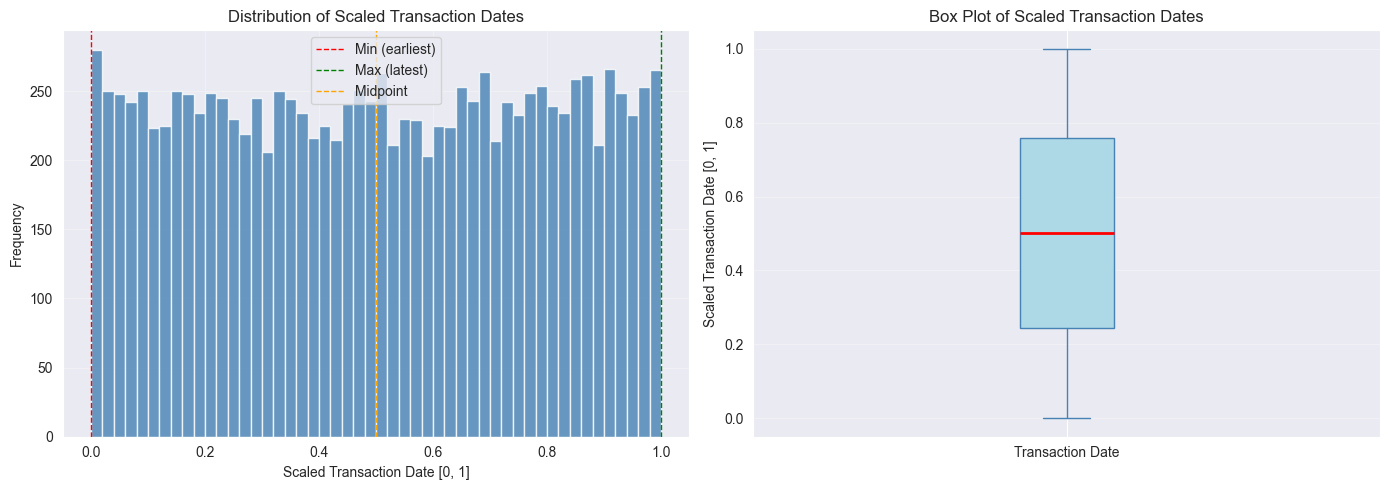


Scaled Transaction Date Summary:
  Mean:   0.5014
  Median: 0.5013
  Std:    0.2926
  Q1:     0.2435
  Q3:     0.7583


In [7]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram of scaled dates
axes[0].hist(df[DATE_SCALED_COL], bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Scaled Transaction Date [0, 1]')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Scaled Transaction Dates')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1, label='Min (earliest)')
axes[0].axvline(1, color='green', linestyle='--', linewidth=1, label='Max (latest)')
axes[0].axvline(0.5, color='orange', linestyle='--', linewidth=1, label='Midpoint')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Box plot
axes[1].boxplot(df[DATE_SCALED_COL], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='steelblue'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='steelblue'),
                capprops=dict(color='steelblue'))
axes[1].set_ylabel('Scaled Transaction Date [0, 1]')
axes[1].set_title('Box Plot of Scaled Transaction Dates')
axes[1].set_xticklabels(['Transaction Date'])
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nScaled Transaction Date Summary:")
print(f"  Mean:   {df[DATE_SCALED_COL].mean():.4f}")
print(f"  Median: {df[DATE_SCALED_COL].median():.4f}")
print(f"  Std:    {df[DATE_SCALED_COL].std():.4f}")
print(f"  Q1:     {df[DATE_SCALED_COL].quantile(0.25):.4f}")
print(f"  Q3:     {df[DATE_SCALED_COL].quantile(0.75):.4f}")

## Step 6: Save Output

Save the dataset with all three date columns: original, numeric, and scaled.

In [8]:
# Create output directory if it doesn't exist
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# Save to CSV
df.to_csv(OUTPUT_CSV, index=False)